In [1]:
# Librerias utilizadas.
## Importación de datos.
from sqlalchemy import create_engine
## Tratamiento de datos.
import pandas as pd
import numpy as np
## Gráficos.
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10
## Preprocesado y modelado.
from sklearn import datasets, linear_model, metrics, svm, preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV
## Configuración warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Nombre de usuario, contraseña y BBDD MySQL.
mysql_address = '172.30.248.86'
mysql_port = '3306'
mysql_username = 'mms'
mysql_password = 'agedb'
mysql_dbname = 'aoe2de'
# String que contiene la información necesaria para el login de MySQL.
mysql_str = ('mysql+pymysql://{username}:{password}@{ipaddress}:{port}/{dbname}'
.format(username = mysql_username,
password = mysql_password,
ipaddress = mysql_address,
port = mysql_port,
dbname = mysql_dbname))

In [3]:
# Query para importar los datos desde MySQL.
cnx = create_engine(mysql_str)
query = f"""
/*ALL PLAYERS*/
SELECT
    matches.duration_minutes AS 'duration',
    players.civ,
    players.won
FROM
    matches, players
WHERE
    matches.match_id = players.match_id
AND
    matches.map_type = 'Arabia'
AND
    matches.rating_type = '1v1 Random Map'
AND
    matches.version = '46295'    
"""
df = pd.read_sql_query(query, con=cnx)
# Muestreo aleatorio simple de 10000 observaciones.
df = df.sample(n=30000, random_state=2021).reset_index(drop=True)
df.shape

(30000, 3)

In [4]:
df.head(10)

,duration,civ,won
0,21,Berbers,1
1,17,Turks,0
2,20,Spanish,1
3,27,Chinese,1
4,18,Incas,1
5,10,Mayans,0
6,26,Aztecs,1
7,24,Lithuanians,1
8,4,Malians,1
9,17,Britons,0


In [5]:
df.tail(10)

,duration,civ,won
29990,3,Ethiopians,1
29991,18,Goths,0
29992,16,Vietnamese,1
29993,30,Mongols,1
29994,29,Franks,0
29995,32,Magyars,1
29996,19,Britons,1
29997,22,Huns,1
29998,33,Vikings,1
29999,5,Aztecs,0


In [6]:
# Comprobación de valores NaN en el dataset.
df.isna().sum()

duration    0
civ         0
won         0
dtype: int64

In [7]:
# Eliminar registros donde tenemos alguna variable NaN.
df.dropna(inplace=True)
df.shape

(30000, 3)

In [8]:
# Convertir variables object a category.
df['civ'] = df['civ'].astype('category')

In [9]:
# Comprobación de cada tipo de variable.
df.dtypes

duration       int64
civ         category
won            int64
dtype: object

In [10]:
# Estadísticos básicos de las variables numéricas.
df.describe()

,duration,won
count,30000.000000,30000.000000
mean,24.342633,0.502533
std,11.125192,0.500002
min,0.000000,0.000000
25%,17.000000,0.000000
50%,24.000000,1.000000
75%,31.000000,1.000000
max,189.000000,1.000000


<AxesSubplot:xlabel='duration', ylabel='Density'>

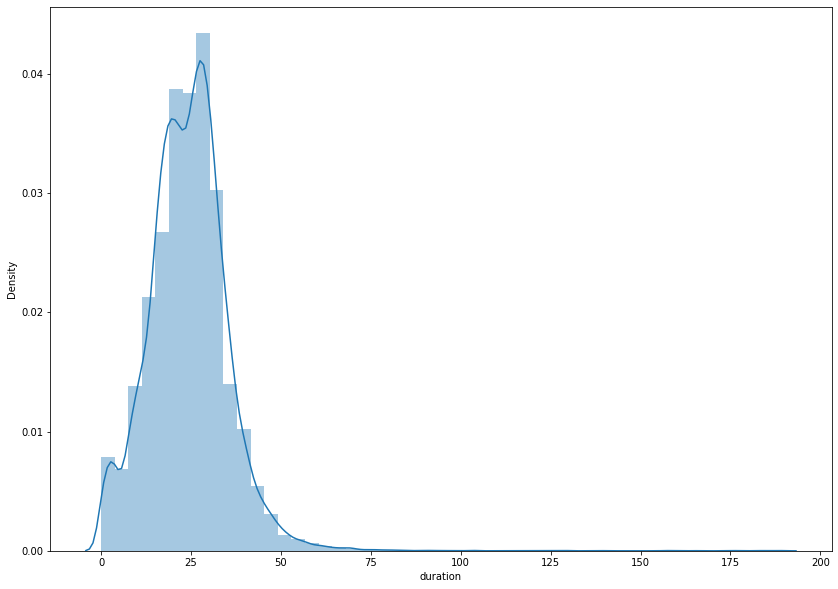

In [11]:
sns.distplot(df.duration)

<AxesSubplot:xlabel='duration'>

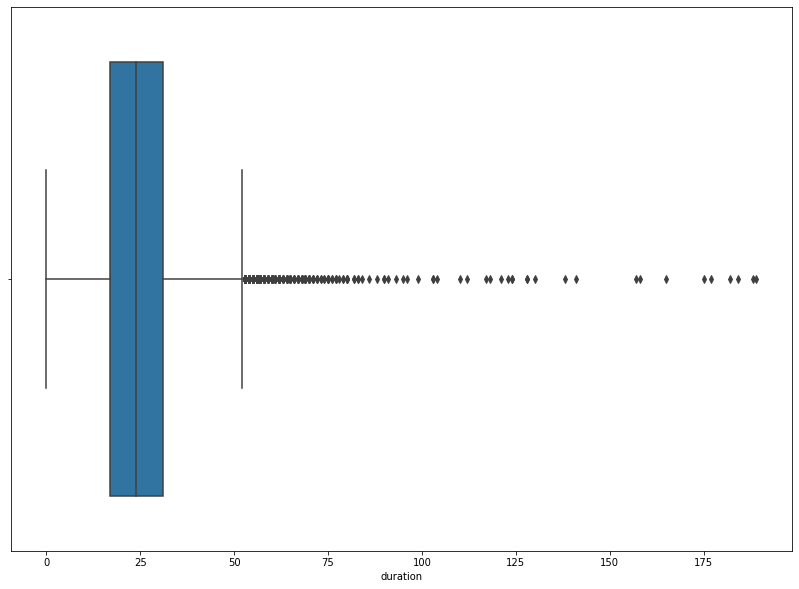

In [12]:
sns.boxplot(df.duration)

In [13]:
# Valores únicos de la variable "civ".
civs = df.civ.unique().tolist()
civs.sort()
# Creación de la función personalizada "obtener los índices de frecuencia por país".
def get_frequency_rates_by_civ(df):
    return pd.DataFrame(df.civ.value_counts(normalize=True)).reset_index().rename(columns={"index": "civ", "civ": "frequency"})
# Creación de la función personalizada "obtener las tasas de victoria por país".
def get_win_rates_by_civ(df):
    return (
        df.groupby("civ")["won"]
            .mean()
            .reset_index()
            .rename(columns={"won": "win_rate"})
            .sort_values("win_rate", ascending=False)
            .reset_index(drop=True)
    )
# Aplicación de las dos funciones creadas anteriormente.
frequency_rates_civ = get_frequency_rates_by_civ(df)
win_rates_civ              = get_win_rates_by_civ(df)

Text(0.5, 1.0, 'Frecuencia de partidas por civilización')

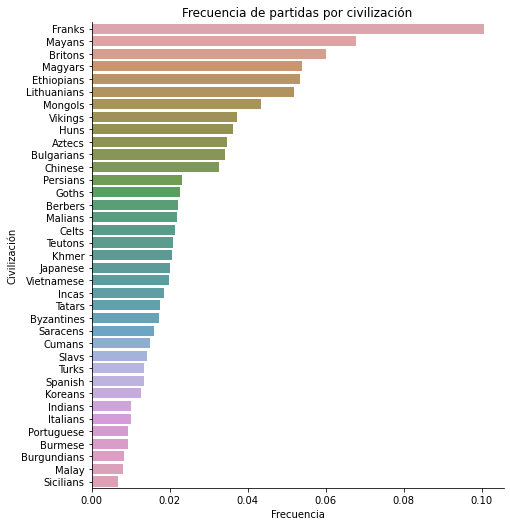

In [14]:
sns.catplot(y="civ",
                        x="frequency", 
                        data=frequency_rates_civ,
                        saturation=0.5,
                        kind="bar",
                        ci=None,
                        aspect=1,
                        height=7,
                        orient="h",
                        order=frequency_rates_civ.sort_values('frequency', ascending=False).civ)
plt.ylabel("Civilización")
plt.xlabel("Frecuencia")
plt.title("Frecuencia de partidas por civilización")

Text(0.5, 1.0, 'Tasa de victorias por civilización')

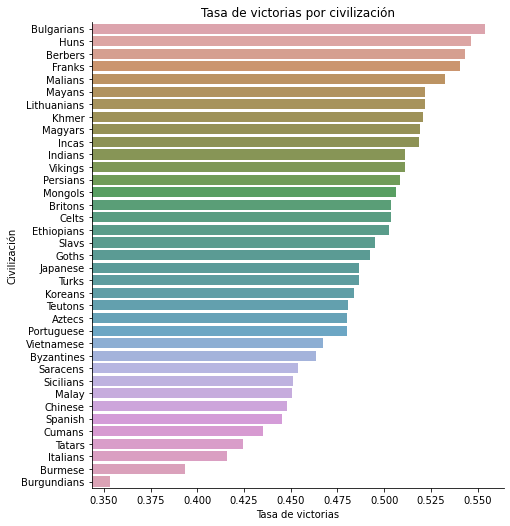

In [15]:
sns.catplot(y="civ",
                        x="win_rate", 
                        data=win_rates_civ,
                        saturation=0.5,
                        kind="bar",
                        ci=None,
                        aspect=1,
                        height=7,
                        orient="h", 
                        order=win_rates_civ.sort_values('win_rate', ascending=False).civ)
plt.ylabel("Civilización")
plt.xlabel("Tasa de victorias")
lim_sup = float(win_rates_civ.win_rate.head(1) + 0.01)
lim_inf = float(win_rates_civ.win_rate.tail(1) - 0.01)
plt.xlim(lim_inf, lim_sup)
plt.title("Tasa de victorias por civilización")

In [16]:
# Función para la creación de variables dummy.
def create_dummies(df, var_name):
    dummy = pd.get_dummies(df[var_name], prefix=var_name)
    df = df.drop(var_name, axis = 1)
    df = pd.concat([df, dummy ], axis = 1)
    return df
# Creación variables dummy.
categorical = ["civ"]
for category in categorical:
    df = create_dummies(df, category)

In [17]:
# Transformación de las entidades escalando cada entidad a un rango determinado.
scaler = MinMaxScaler() 
arr_scaled = scaler.fit_transform(df) 
df_scaled = pd.DataFrame(arr_scaled, columns=df.columns,index=df.index)
df_scaled

,duration,won,civ_Aztecs,civ_Berbers,civ_Britons,civ_Bulgarians,civ_Burgundians,civ_Burmese,civ_Byzantines,civ_Celts,...,civ_Portuguese,civ_Saracens,civ_Sicilians,civ_Slavs,civ_Spanish,civ_Tatars,civ_Teutons,civ_Turks,civ_Vietnamese,civ_Vikings
0,0.111111,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.089947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.105820,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.142857,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.095238,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.169312,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29996,0.100529,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29997,0.116402,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29998,0.174603,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [18]:
# Selección de rasgos para el modelo.
features = len(df_scaled.columns.values)
summary_models_logreg = pd.DataFrame(columns=['initial_features', 
                                                                                                       'final_features',
                                                                                                       'aic',
                                                                                                       'bic',
                                                                                                       'df_residuals',
                                                                                                       'r_squared',
                                                                                                       'score_accuracy',
                                                                                                       'roc_auc_score'])
for f in range(4, features, 4):
    print("-------------")
    print("Features:", f)
    # Recursive Feature Elimination
    df_vars=df_scaled.columns.values.tolist()
    y_var=['won']
    X_var=[i for i in df_vars if i not in y_var]
    y = pd.DataFrame(data=df_scaled,columns=y_var)
    X = pd.DataFrame(data=df_scaled,columns=X_var)
    logreg_sklearn = LogisticRegression()
    rfe = RFE(logreg_sklearn, f)
    try:
        rfe = rfe.fit(X, y.values.ravel())
        cols = []
        for var, selected, rank in zip(X_var, rfe.support_, rfe.ranking_):
            if selected == True:
                cols.append(var)
        X=df_scaled[cols]
        y=df_scaled['won']

        # Implementing the model
        logreg_sm=sm.Logit(y,X)
        logreg_sm_results=logreg_sm.fit()

        # Remove unsignificant variables
        pvalues = list(logreg_sm_results.pvalues)
        cols_s = pd.DataFrame(list(zip(cols, pvalues)))
        cols_s.columns = ["variable", "pvalue"]
        cols_s = cols_s[cols_s["pvalue"] <= 0.05]
        cols_s.reset_index(inplace=True, drop=True)
        cols_s = list(cols_s["variable"])
        X=df_scaled[cols_s]
        y=df_scaled['won']
        logreg_sm=sm.Logit(y,X)
        logreg_sm_results=logreg_sm.fit()

        # Logistic Regression Model Fitting
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
        logreg_sklearn = LogisticRegression()
        logreg_sklearn.fit(X_train, y_train)
        from sklearn.metrics import roc_auc_score
        logreg_sklearn_roc_auc = roc_auc_score(y_test, logreg_sklearn.predict(X_test))

        # Final features.
        final_features = len(logreg_sm_results.params)
        # Akaike’s information criteria.
        aic = round(logreg_sm_results.aic, 4)
        # Bayes’ information criteria.
        bic = round(logreg_sm_results.bic, 4)
        # Residual degrees of freedom.
        df_resid = int(logreg_sm_results.df_resid)
        # R squared.
        rsquared = round(logreg_sm_results.prsquared, 4)
        # Score of logreg_sklearn.
        score_accuracy = round(logreg_sklearn.score(X_test, y_test), 4)
        # Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
        roc_auc_score = round(logreg_sklearn_roc_auc, 4)

        # Append to final dataframe summary of logistic regression.
        data_to_append = [f, final_features, aic, bic, df_resid, rsquared, score_accuracy, roc_auc_score]
        a_series = pd.Series(data_to_append, index=summary_models_logreg.columns)
        summary_models_logreg = summary_models_logreg.append(a_series, ignore_index=True)
    except:
        pass

-------------
Features: 4
Optimization terminated successfully.
         Current function value: 0.692307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692307
         Iterations 4
-------------
Features: 8
Optimization terminated successfully.
         Current function value: 0.691521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691521
         Iterations 4
-------------
Features: 12
Optimization terminated successfully.
         Current function value: 0.691202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691256
         Iterations 4
-------------
Features: 16
Optimization terminated successfully.
         Current function value: 0.690883
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691036
         Iterations 4
-------------
Features: 20
Optimization terminated successfully.
         Curr

In [19]:
summary_models_logreg = summary_models_logreg[summary_models_logreg["r_squared"]>0]
summary_models_logreg = summary_models_logreg.sort_values(by=['score_accuracy', 'roc_auc_score', 'r_squared'], ascending=[False, False, False]).reset_index(drop=True)
summary_models_logreg.head(10)

,initial_features,final_features,aic,bic,df_residuals,r_squared,score_accuracy,roc_auc_score
0,36.0,13.0,41486.0585,41594.0749,29987.0,0.0031,0.5291,0.5214
1,16.0,13.0,41488.1585,41596.1749,29987.0,0.0030,0.5271,0.5227
2,12.0,11.0,41497.3720,41588.7705,29989.0,0.0027,0.5257,0.5196
3,24.0,12.0,41484.3345,41584.0420,29988.0,0.0031,0.5244,0.5159
4,28.0,12.0,41484.3345,41584.0420,29988.0,0.0031,0.5244,0.5159
5,32.0,12.0,41484.3345,41584.0420,29988.0,0.0031,0.5244,0.5159
6,20.0,11.0,41487.3768,41578.7753,29989.0,0.0029,0.5244,0.5159
7,8.0,8.0,41507.2767,41573.7483,29992.0,0.0023,0.5158,0.5095
8,4.0,4.0,41546.4156,41579.6514,29996.0,0.0012,0.4979,0.4959


In [20]:
f = int(summary_models_logreg.initial_features[0])
# Recursive Feature Elimination
df_vars=df_scaled.columns.values.tolist()
y_var=['won']
X_var=[i for i in df_vars if i not in y_var]
y = pd.DataFrame(data=df_scaled,columns=y_var)
X = pd.DataFrame(data=df_scaled,columns=X_var)
logreg_sklearn = LogisticRegression()
rfe = RFE(logreg_sklearn, f)
rfe = rfe.fit(X, y.values.ravel())
cols = []
for var, selected, rank in zip(X_var, rfe.support_, rfe.ranking_):
    if selected == True:
        cols.append(var)
X=df_scaled[cols]
y=df_scaled['won']

# Implementing the model
logreg_sm=sm.Logit(y,X)
logreg_sm_results=logreg_sm.fit()

# Remove unsignificant variables
pvalues = list(logreg_sm_results.pvalues)
cols_s = pd.DataFrame(list(zip(cols, pvalues)))
cols_s.columns = ["variable", "pvalue"]
cols_s = cols_s[cols_s["pvalue"] <= 0.05]
cols_s.reset_index(inplace=True, drop=True)
cols_s = list(cols_s["variable"])
X=df_scaled[cols_s]
y=df_scaled['won']
logreg_sm=sm.Logit(y,X)
logreg_sm_results=logreg_sm.fit()

Optimization terminated successfully.
         Current function value: 0.690471
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691001
         Iterations 4


In [21]:
logreg_sm_results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.003     
Dependent Variable: won              AIC:              41486.0585
Date:               2021-07-05 19:06 BIC:              41594.0749
No. Observations:   30000            Log-Likelihood:   -20730.   
Df Model:           12               LL-Null:          -20794.   
Df Residuals:       29987            LLR p-value:      1.5530e-21
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     4.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
civ_Bulgarians     0.2166   0.0627  3.4536 0.0006  0.0937  0.3395
civ_Burgundians   -0.6041   0.1326 -4.5566 0.0000 -0.8639 -0.3442
civ_Burmese       -0.4326   0.1230 -3.5175 0.0004 -0.6737 -0.1916
civ_Byzantines    -0.1459   0.0878 -1.6617 0.0966 -0.3179  0.0262
civ_Chinese       -0.2085   0.0642 -3.2491 0.0012 -0.3343 -0.0827
civ_Cumans        -0.2616   0.0955 -2.7386 0.0062 -0.4488 -0.0744
civ_Franks         0.1627   0.0365  4.4541 0.0000  0.0911  0.2342
civ_Huns           0.1857   0.0608  3.0534 0.0023  0.0665  0.3049
civ_Italians      -0.3399   0.1166 -2.9158 0.0035 -0.5683 -0.1114
civ_Saracens      -0.1846   0.0919 -2.0097 0.0445 -0.3647 -0.0046
civ_Spanish       -0.2198   0.1004 -2.1901 0.0285 -0.4165 -0.0231
civ_Tatars        -0.3042   0.0879 -3.4616 0.0005 -0.4765 -0.1320
civ_Vietnamese    -0.1308   0.0820 -1.5950 0.1107 -0.2916  0.0299
=================================================================

"""

In [22]:
coefficients = dict(logreg_sm_results.params)
coefficients = pd.DataFrame.from_dict(coefficients, orient='index').reset_index(level=0)
coefficients.columns = ['Variable', 'Coeficiente']
coefficients.sort_values(by="Coeficiente", ascending=False)

,Variable,Coeficiente
0,civ_Bulgarians,0.216586
7,civ_Huns,0.185683
6,civ_Franks,0.162663
12,civ_Vietnamese,-0.130840
3,civ_Byzantines,-0.145852
9,civ_Saracens,-0.184623
4,civ_Chinese,-0.208491
10,civ_Spanish,-0.219786
5,civ_Cumans,-0.261571
11,civ_Tatars,-0.304211


In [23]:
for index, row in coefficients.iterrows():
    print("Si el jugador escoge la civilización " + row["Variable"] + " el cociente de probabilidad de victoria se incrementará en " + str(round(row["Coeficiente"], 3)))

Si el jugador escoge la civilización civ_Bulgarians el cociente de probabilidad de victoria se incrementará en 0.217
Si el jugador escoge la civilización civ_Burgundians el cociente de probabilidad de victoria se incrementará en -0.604
Si el jugador escoge la civilización civ_Burmese el cociente de probabilidad de victoria se incrementará en -0.433
Si el jugador escoge la civilización civ_Byzantines el cociente de probabilidad de victoria se incrementará en -0.146
Si el jugador escoge la civilización civ_Chinese el cociente de probabilidad de victoria se incrementará en -0.208
Si el jugador escoge la civilización civ_Cumans el cociente de probabilidad de victoria se incrementará en -0.262
Si el jugador escoge la civilización civ_Franks el cociente de probabilidad de victoria se incrementará en 0.163
Si el jugador escoge la civilización civ_Huns el cociente de probabilidad de victoria se incrementará en 0.186
Si el jugador escoge la civilización civ_Italians el cociente de probabilidad 

In [24]:
corr = X.corr().abs()
corr = corr[corr > 0.7]
corr

,civ_Bulgarians,civ_Burgundians,civ_Burmese,civ_Byzantines,civ_Chinese,civ_Cumans,civ_Franks,civ_Huns,civ_Italians,civ_Saracens,civ_Spanish,civ_Tatars,civ_Vietnamese
civ_Bulgarians,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
civ_Burgundians,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
civ_Burmese,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
civ_Byzantines,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
civ_Chinese,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
civ_Cumans,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
civ_Franks,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
civ_Huns,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
civ_Italians,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
civ_Saracens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


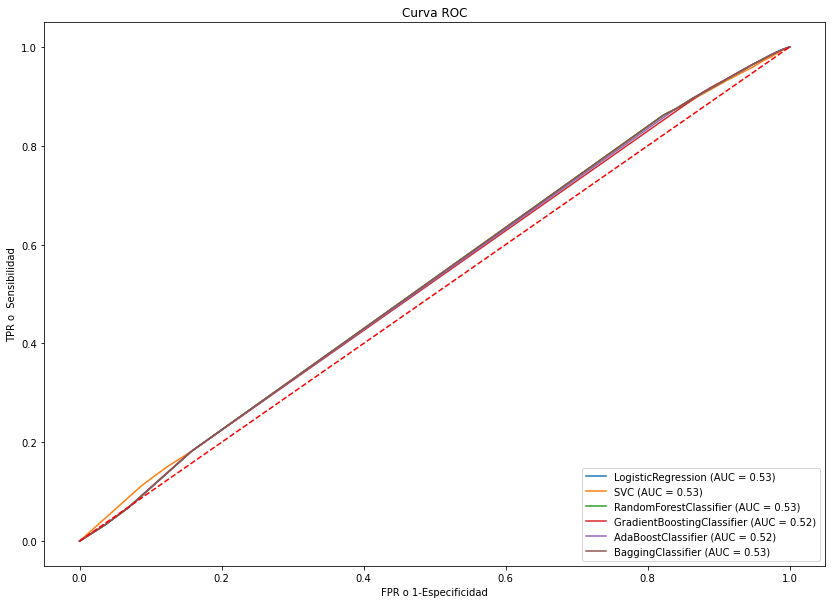

In [25]:
from sklearn.metrics import plot_roc_curve

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)
ax=plt.gca()
# LogisticRegression
logreg_sklearn = LogisticRegression()
logreg_sklearn.fit(X_train, y_train)
logreg_sklearn_roc = plot_roc_curve(logreg_sklearn, X_test, y_test, ax=ax)
# SVC (Support Vector Classification)
svc_sklearn = SVC(random_state=2021)
svc_sklearn.fit(X_train, y_train)
svc_sklearn_roc = plot_roc_curve(svc_sklearn, X_test, y_test, ax=ax)
# RandomForestClassifier
rfc_sklearn = RandomForestClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
rfc_sklearn.fit(X_train, y_train)
rfc_sklearn_roc = plot_roc_curve(rfc_sklearn, X_test, y_test, ax=ax)
# GradientBoostingClassifier
gbc_sklearn = GradientBoostingClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
gbc_sklearn.fit(X_train, y_train)
gbc_sklearn_roc = plot_roc_curve(gbc_sklearn, X_test, y_test, ax=ax)
# AdaBoostClassifier
abc_sklearn = AdaBoostClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
abc_sklearn.fit(X_train, y_train)
abc_sklearn_roc = plot_roc_curve(abc_sklearn, X_test, y_test, ax=ax)
# BaggingClassifier
bgc_sklearn =BaggingClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
bgc_sklearn.fit(X_train, y_train)
bgc_sklearn_roc = plot_roc_curve(bgc_sklearn, X_test, y_test, ax=ax)

plt.title("Curva ROC")
plt.ylabel("TPR o  Sensibilidad")
plt.xlabel("FPR o 1-Especificidad")
plt.plot([0, 1], [0, 1],'r--')
rcParams['figure.figsize'] = 16, 10
# plt.rcParams["figure.figsize"] = (12, 12)
plt.show()

In [26]:
# Scores.
score_lr     = round(logreg_sklearn.score(X_test, y_test), 5)
score_svc = round(svc_sklearn.score(X_test, y_test), 5)
score_rfc  = round(rfc_sklearn.score(X_test, y_test), 5)
score_gbc = round(gbc_sklearn.score(X_test, y_test), 5)
score_abc = round(abc_sklearn.score(X_test, y_test), 5)
score_bgc = round(bgc_sklearn.score(X_test, y_test), 5)
# Asignar datos de la lista.  
results = {'Model': ['LogisticRegression', 'SVC (SupportVectorClassifier)', 'RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'BaggingClassifier'],
               'Score': [score_lr, score_svc, score_rfc, score_gbc, score_abc, score_bgc]}  
# Crear DataFrame .
df_results = pd.DataFrame(results)  
# Imprimir listado de Scores.  
df_results.sort_values(by=['Score'], ascending=False, ignore_index=True)

,Model,Score
0,LogisticRegression,0.52156
1,SVC (SupportVectorClassifier),0.52156
2,RandomForestClassifier,0.52156
3,BaggingClassifier,0.52156
4,AdaBoostClassifier,0.51933
5,GradientBoostingClassifier,0.51711


In [27]:
# Scores CV.
score_lr_cv     = round(cross_val_score(logreg_sklearn, X, y, cv=10).mean(), 5)
score_svc_cv = round(cross_val_score(svc_sklearn, X, y, cv=10).mean(), 5)
score_rfc_cv  = round(cross_val_score(rfc_sklearn, X, y, cv=10).mean(), 5)
score_gbc_cv = round(cross_val_score(gbc_sklearn, X, y, cv=10).mean(), 5)
score_abc_cv = round(cross_val_score(abc_sklearn, X, y, cv=10).mean(), 5)
score_bgc_cv = round(cross_val_score(bgc_sklearn, X, y, cv=10).mean(), 5)
# Asignar datos de la lista.   
results_cv = {'Model': ['LogisticRegression', 'SVC (SupportVectorClassifier)', 'RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'BaggingClassifier'],
               'Score CV 10': [score_lr_cv, score_svc_cv, score_rfc_cv, score_gbc_cv, score_abc_cv, score_bgc_cv]}  
# Crear DataFrame .
df_results_cv = pd.DataFrame(results_cv)  
# Imprimir listado de Scores CV.  
df_results_cv.sort_values(by=['Score CV 10'], ascending=False, ignore_index=True)

,Model,Score CV 10
0,LogisticRegression,0.52213
1,SVC (SupportVectorClassifier),0.52213
2,RandomForestClassifier,0.52213
3,BaggingClassifier,0.52213
4,AdaBoostClassifier,0.51923
5,GradientBoostingClassifier,0.51527


In [28]:
y.mean()

0.5025333333333334